In [107]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(20200221)

In [59]:
path = "../tests/climate/DailyDelhiClimateTrain.csv"

df = pd.read_csv(path)
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [60]:
print(df.shape)
df['date'] = pd.to_datetime(df['date'])

(1462, 5)


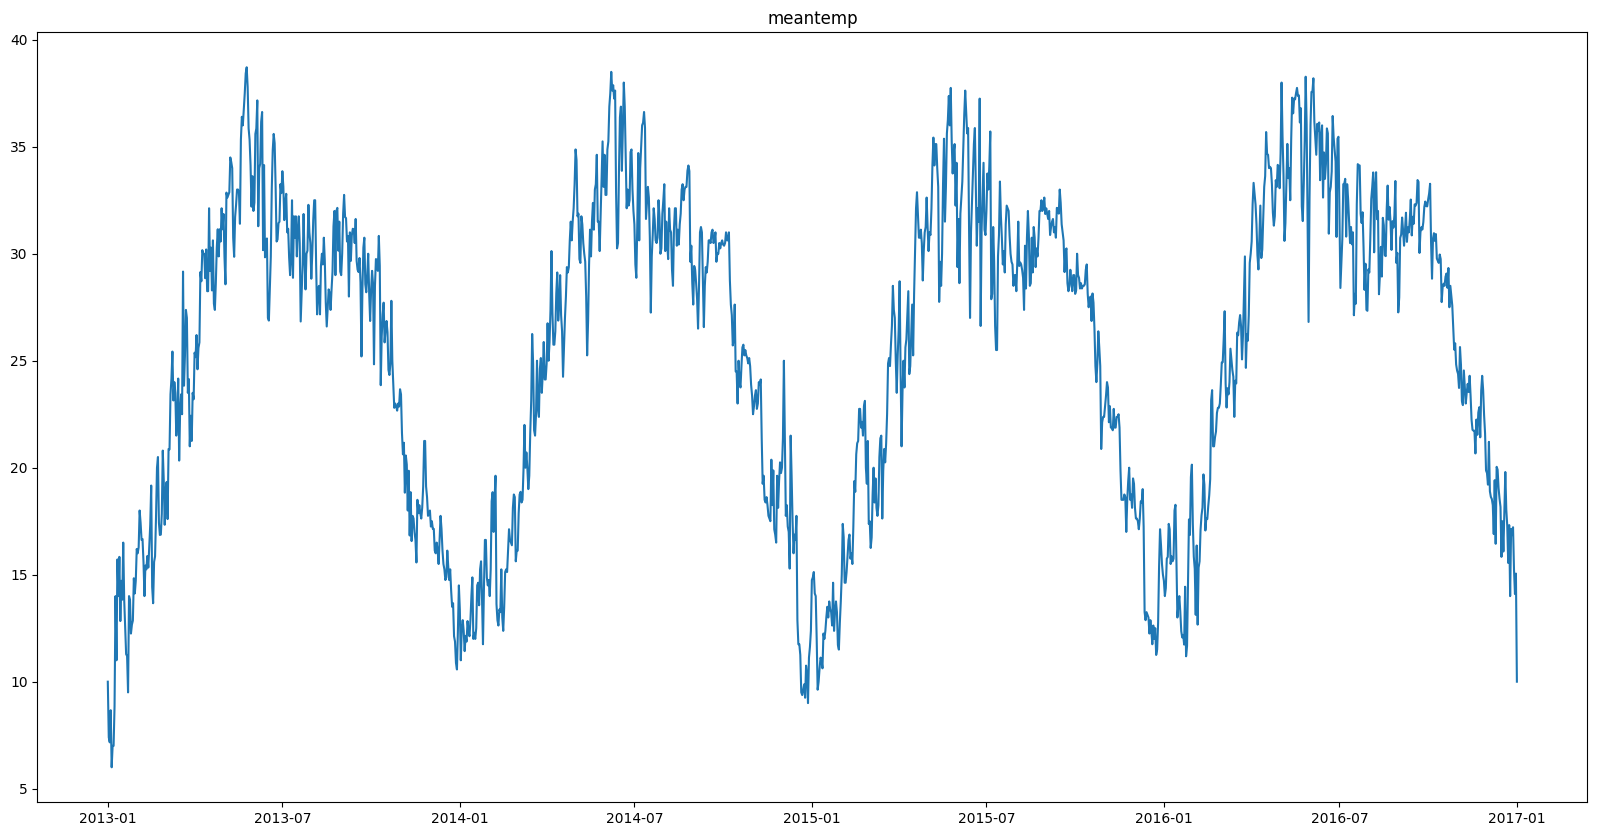

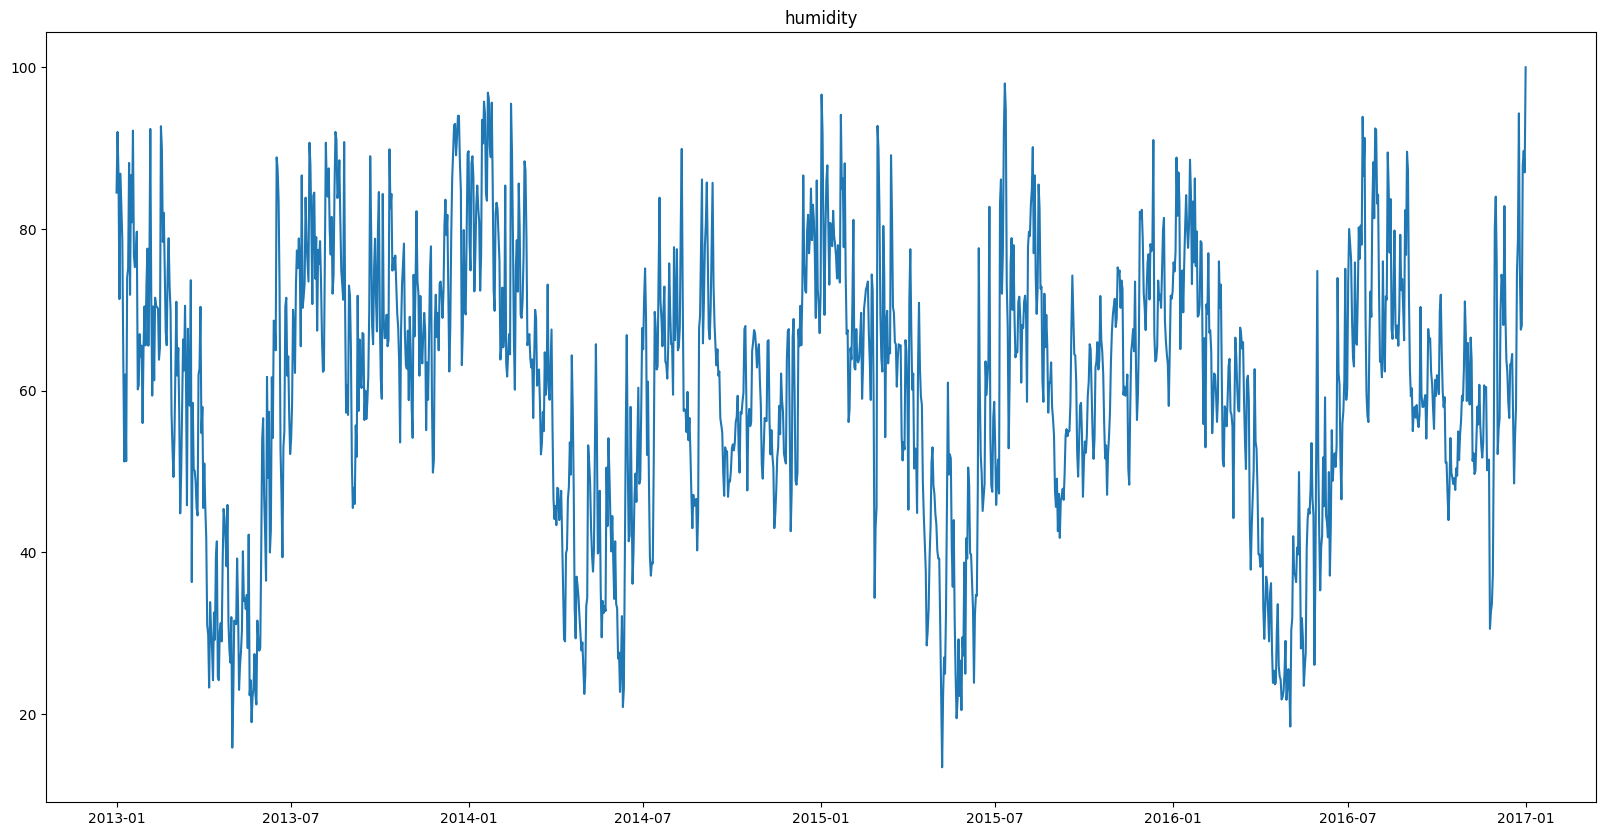

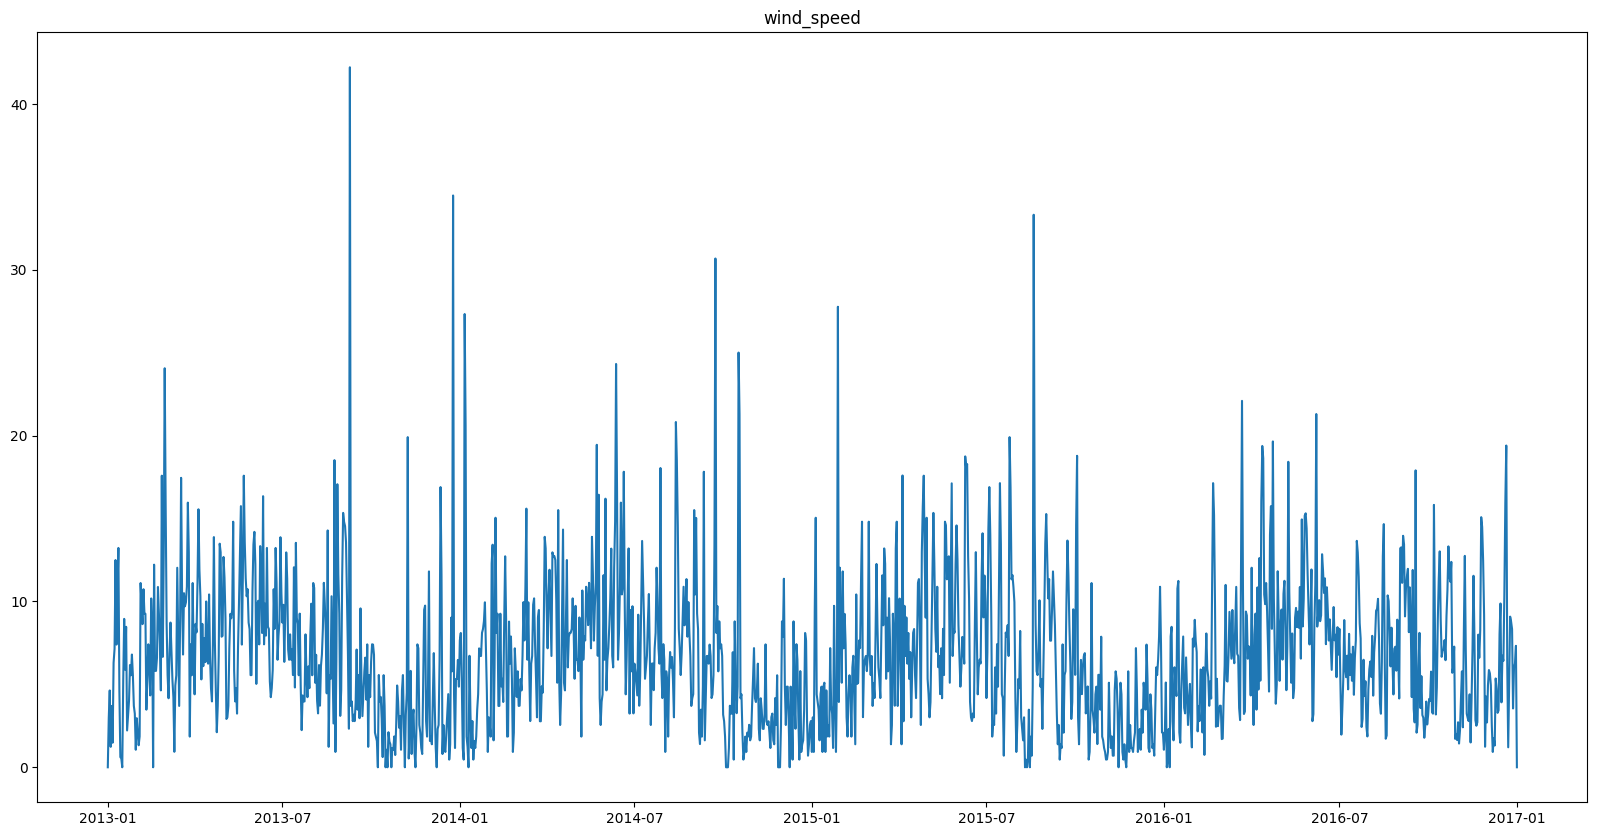

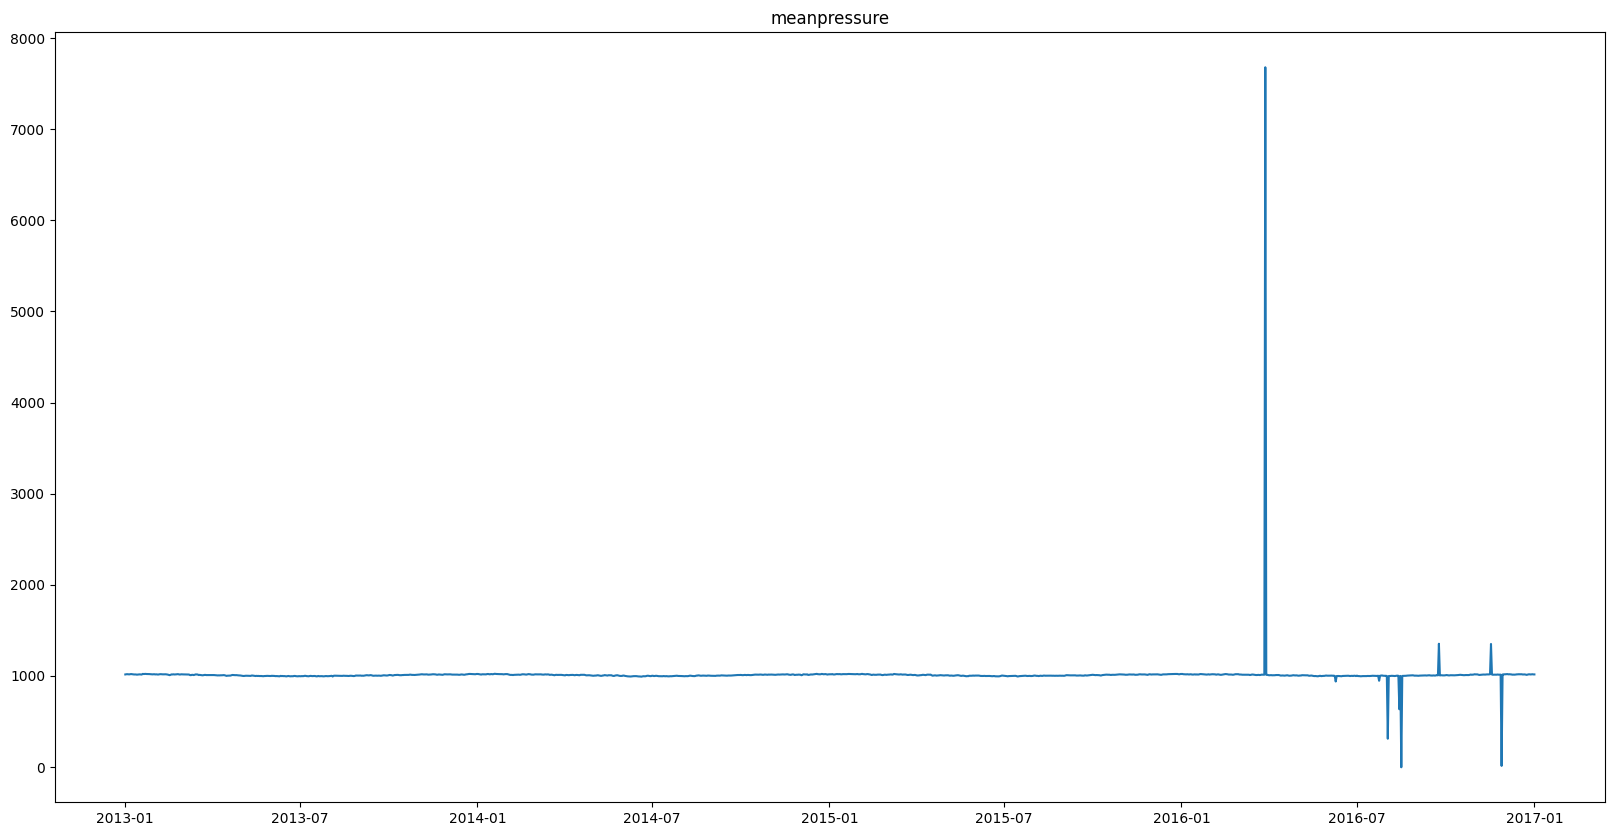

In [61]:
# plot all columns wrt date

for col in df.keys():
    if col == 'date':
        continue
    plt.figure(figsize=(20, 10))
    plt.plot(df['date'], df[col])
    plt.title(col)
    plt.show()


### Synopsis

Meantemp has a seasonal pattern, with the highest temperatures in the summer and the lowest temperatures in the winter.

In [62]:
data = torch.tensor(df['meantemp'].values, dtype=torch.float)
# normalize data
# data = (data - data.mean())/data.std()
data.unsqueeze_(-1)  # Add observation dimension.

tensor([[10.0000],
        [ 7.4000],
        [ 7.1667],
        ...,
        [14.0952],
        [15.0526],
        [10.0000]])

In [63]:
data.shape

torch.Size([1462, 1])

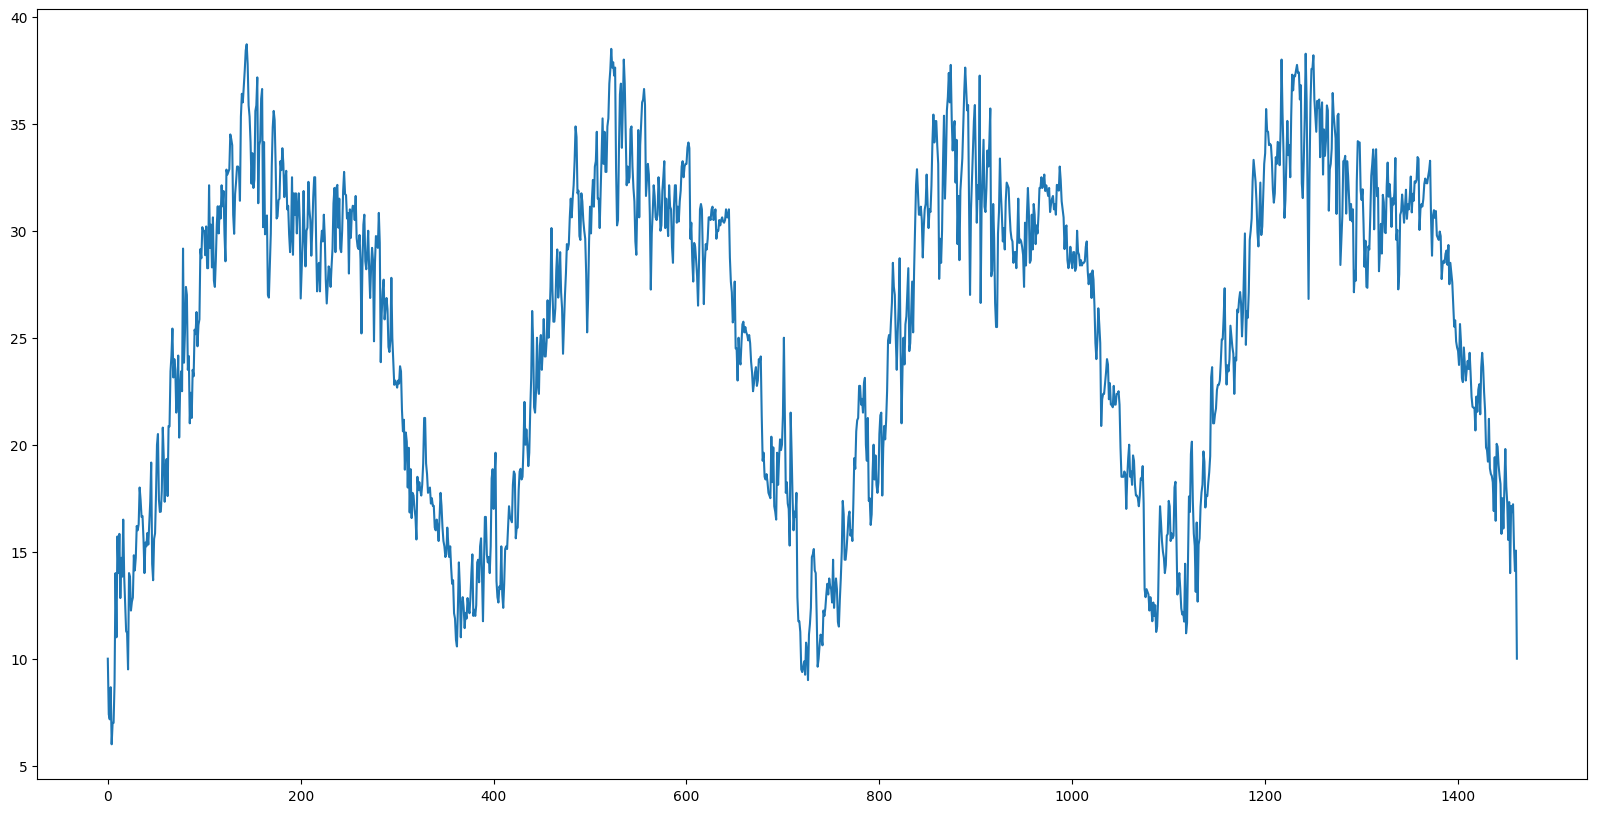

In [64]:
plt.figure(figsize=(20, 10))
plt.plot(data)

# Linear Regression

In [65]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [66]:
test_size = 365
x_train = np.arange(0, len(data) - test_size).reshape(-1, 1)
y_train = data[:len(x_train)]
x_test = np.arange(len(data) - test_size, len(data)).reshape(-1, 1)
y_test = data[len(x_train):]

In [67]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1097, 1), torch.Size([1097, 1]), (365, 1), torch.Size([365, 1]))

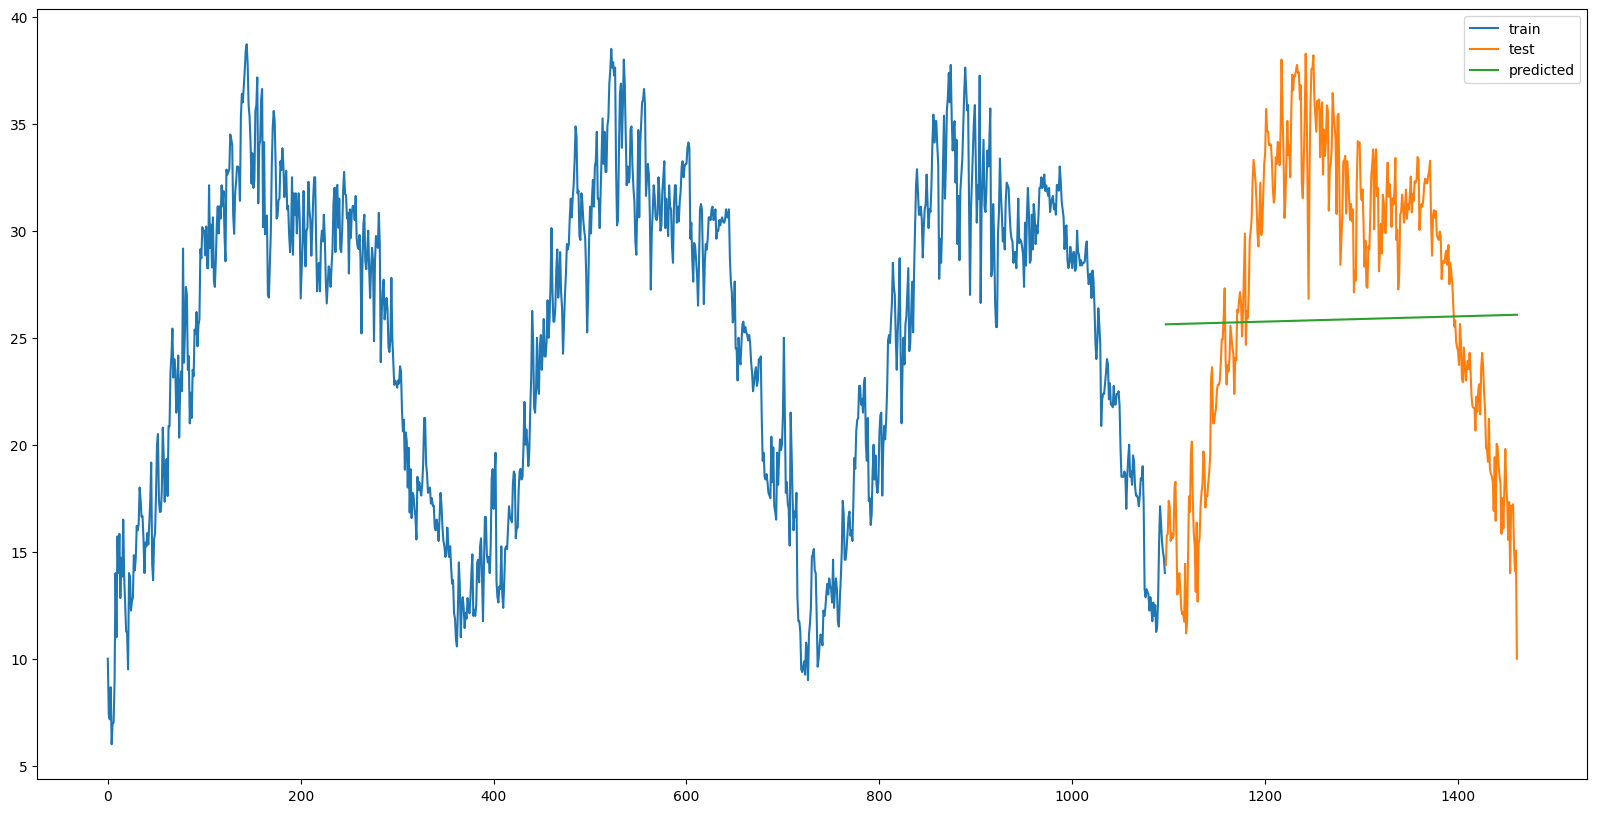

In [68]:

model_linear_reg = LinearRegression().fit(x_train, y_train)
y_predicted = model_linear_reg.predict(x_test)

# plot predictions
x_train_plot = np.arange(0, len(x_train))
x_test_plot = np.arange(len(x_train), len(x_train) + len(x_test))

plt.figure(figsize=(20, 10))
plt.plot(x_train_plot, y_train)
plt.plot(x_test_plot, y_test)
plt.plot(x_test_plot, y_predicted)
plt.legend(['train', 'test', 'predicted'])
plt.show()

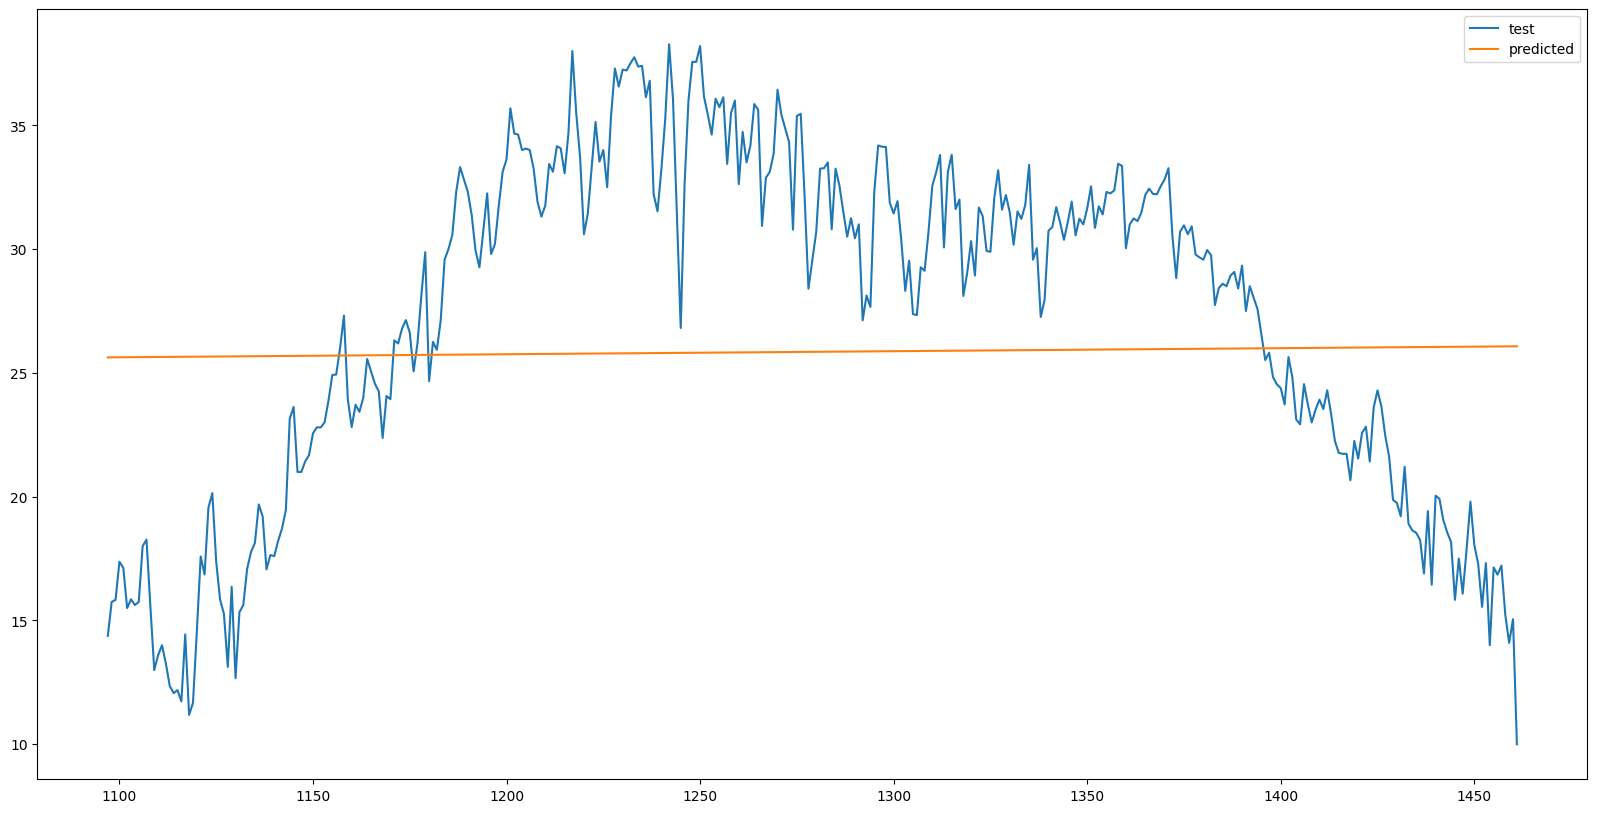

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(x_test_plot, y_test)
plt.plot(x_test_plot, y_predicted)
plt.legend([ 'test', 'predicted'])
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error

print("MSE: ", mean_squared_error(y_test, y_predicted))

MSE:  48.86383596553654


# Pyro

In [112]:
import sys
sys.path.append('../code-external')

import pyro_utils

class BaseModel(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)


Model1 = BaseModel


In [72]:
# normalizing the data
data = torch.tensor(df['meantemp'].values, dtype=torch.float)
data = (data - data.mean())/data.std()
data.unsqueeze_(-1)  # Add observation dimension.

tensor([[-2.1088],
        [-2.4626],
        [-2.4944],
        ...,
        [-1.5515],
        [-1.4212],
        [-2.1088]])

In [113]:
base = 0
end = data.size(-2)
mid = end - 365
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(end)) / 365
covariates = torch.stack([time], dim=-1)
print(covariates.shape, data.shape)
forecaster = Forecaster(Model1(), data[:mid], covariates[:mid], learning_rate=0.1)

INFO 	 step    0 loss = 328523


torch.Size([1462, 1]) torch.Size([1462, 1])


INFO 	 step  100 loss = 1.43711
INFO 	 step  200 loss = 1.44309
INFO 	 step  300 loss = 1.43998
INFO 	 step  400 loss = 1.44856
INFO 	 step  500 loss = 1.44021
INFO 	 step  600 loss = 1.43896
INFO 	 step  700 loss = 1.44047
INFO 	 step  800 loss = 1.43787
INFO 	 step  900 loss = 1.44001
INFO 	 step 1000 loss = 1.4385


torch.Size([1000, 365, 1]) torch.Size([365])


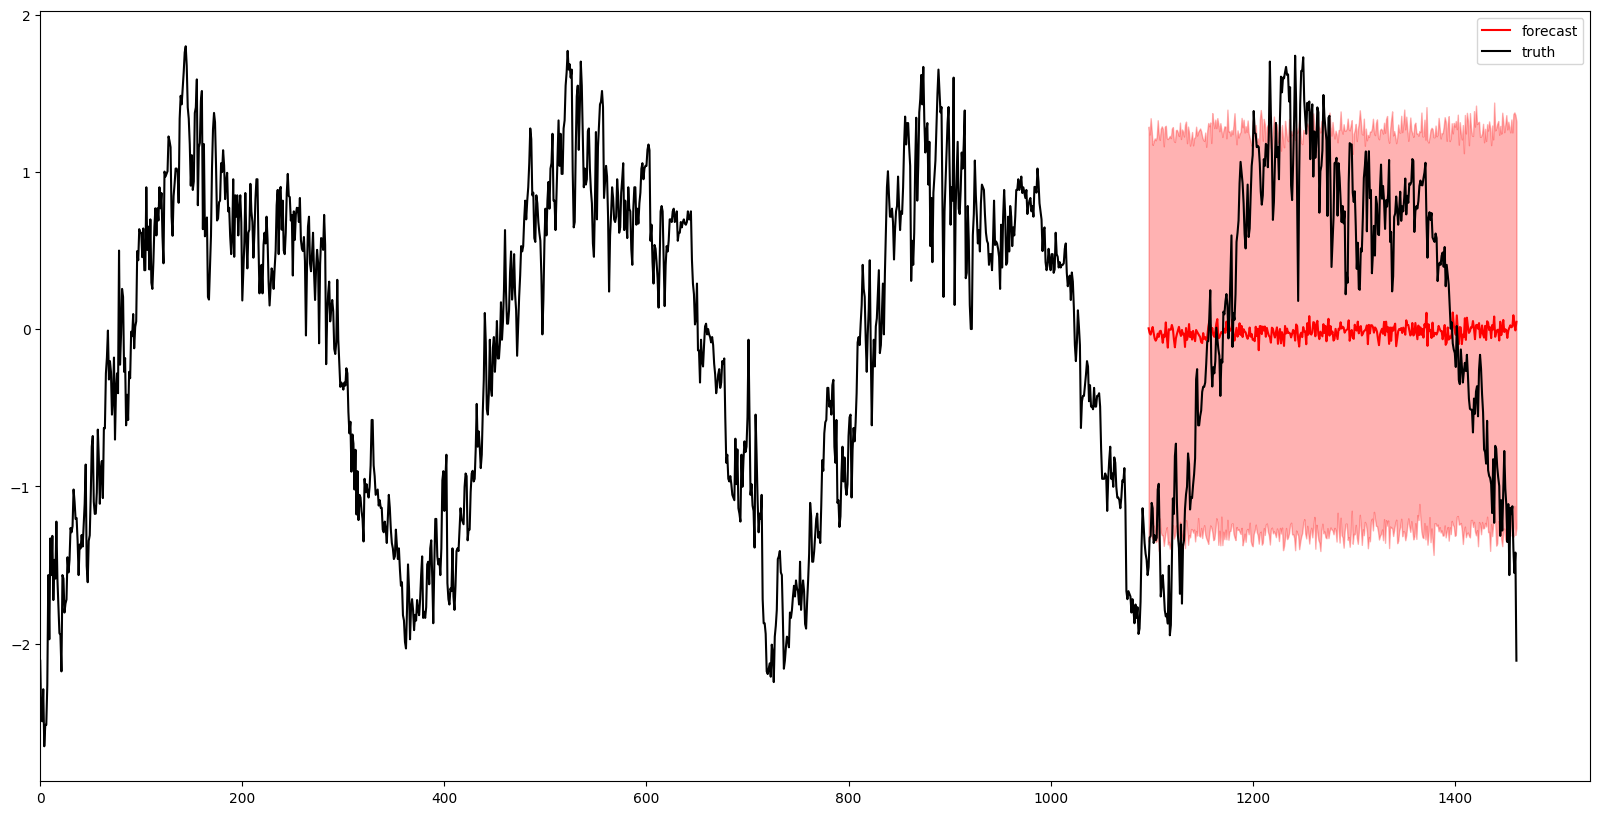

In [114]:
samples = forecaster(data[:mid], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[mid:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.xlim(0, None)
plt.legend(loc="best")
plt.show()

Zooming in, we notice that this model is not capturing the seasonality at all

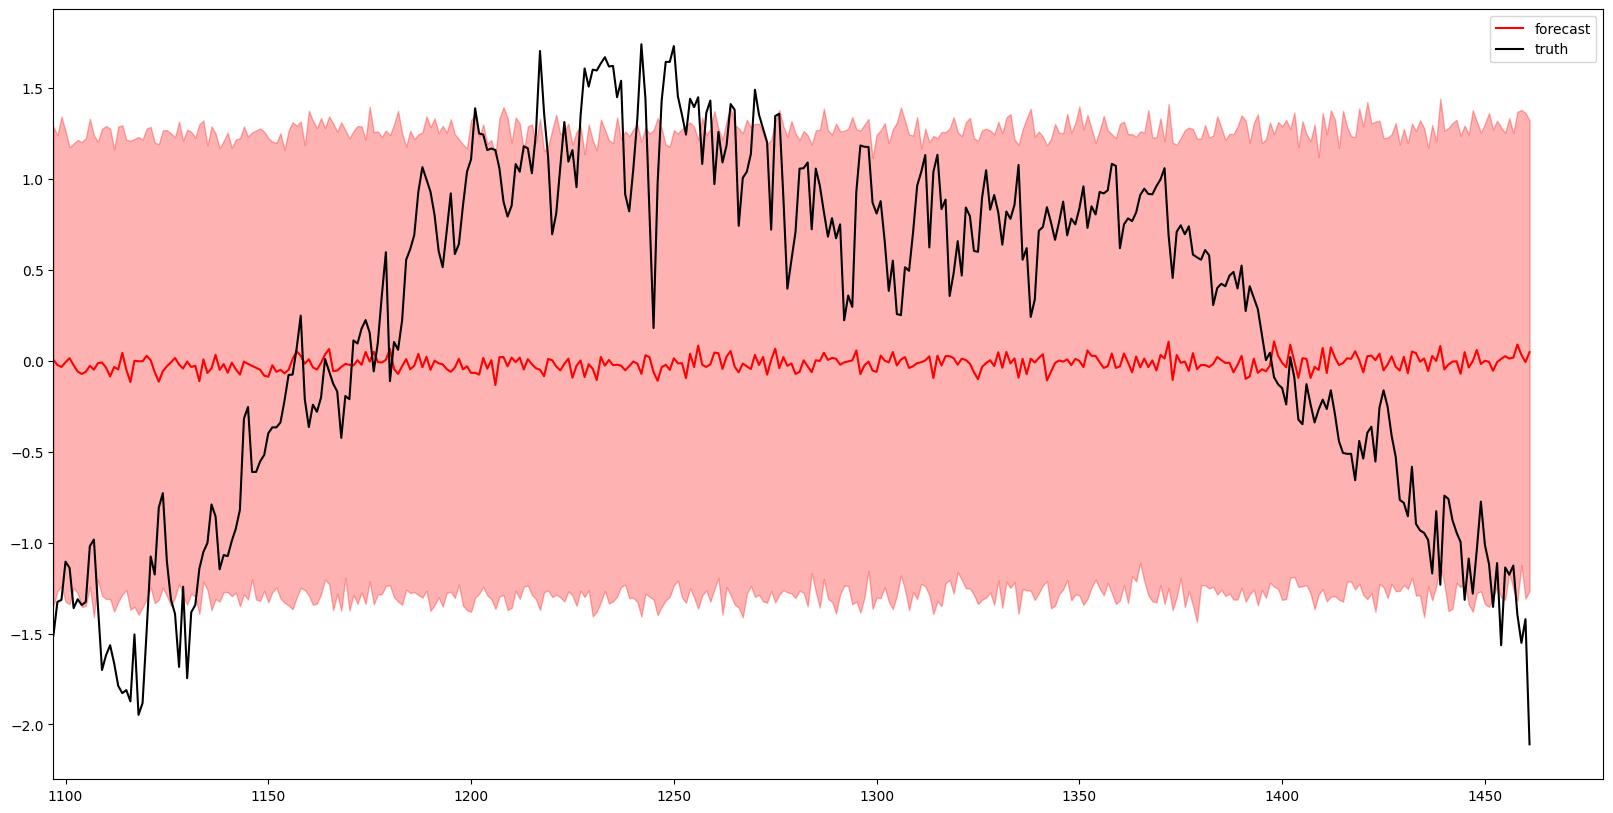

In [75]:
plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(torch.arange(mid, end), data[mid:], 'k-', label='truth')
plt.xlim(mid, None)
plt.legend(loc="best")
plt.show()

In [76]:
# get the total error

from sklearn.metrics import mean_squared_error

print("MSE: ", mean_squared_error(data[mid:], p50))

MSE:  0.9365064


We could add a yearly seasonal component simply by adding new covariates

In [77]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(end)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(end, 365)], dim=-1)
forecaster = Forecaster(Model1(), data[:mid], covariates[:mid], learning_rate=0.1)

INFO 	 step    0 loss = 36799.4


INFO 	 step  100 loss = 1.42929
INFO 	 step  200 loss = 1.33081
INFO 	 step  300 loss = 1.2048
INFO 	 step  400 loss = 1.11445
INFO 	 step  500 loss = 1.06581
INFO 	 step  600 loss = 1.02373
INFO 	 step  700 loss = 0.973948
INFO 	 step  800 loss = 0.915481
INFO 	 step  900 loss = 0.897772
INFO 	 step 1000 loss = 0.895096


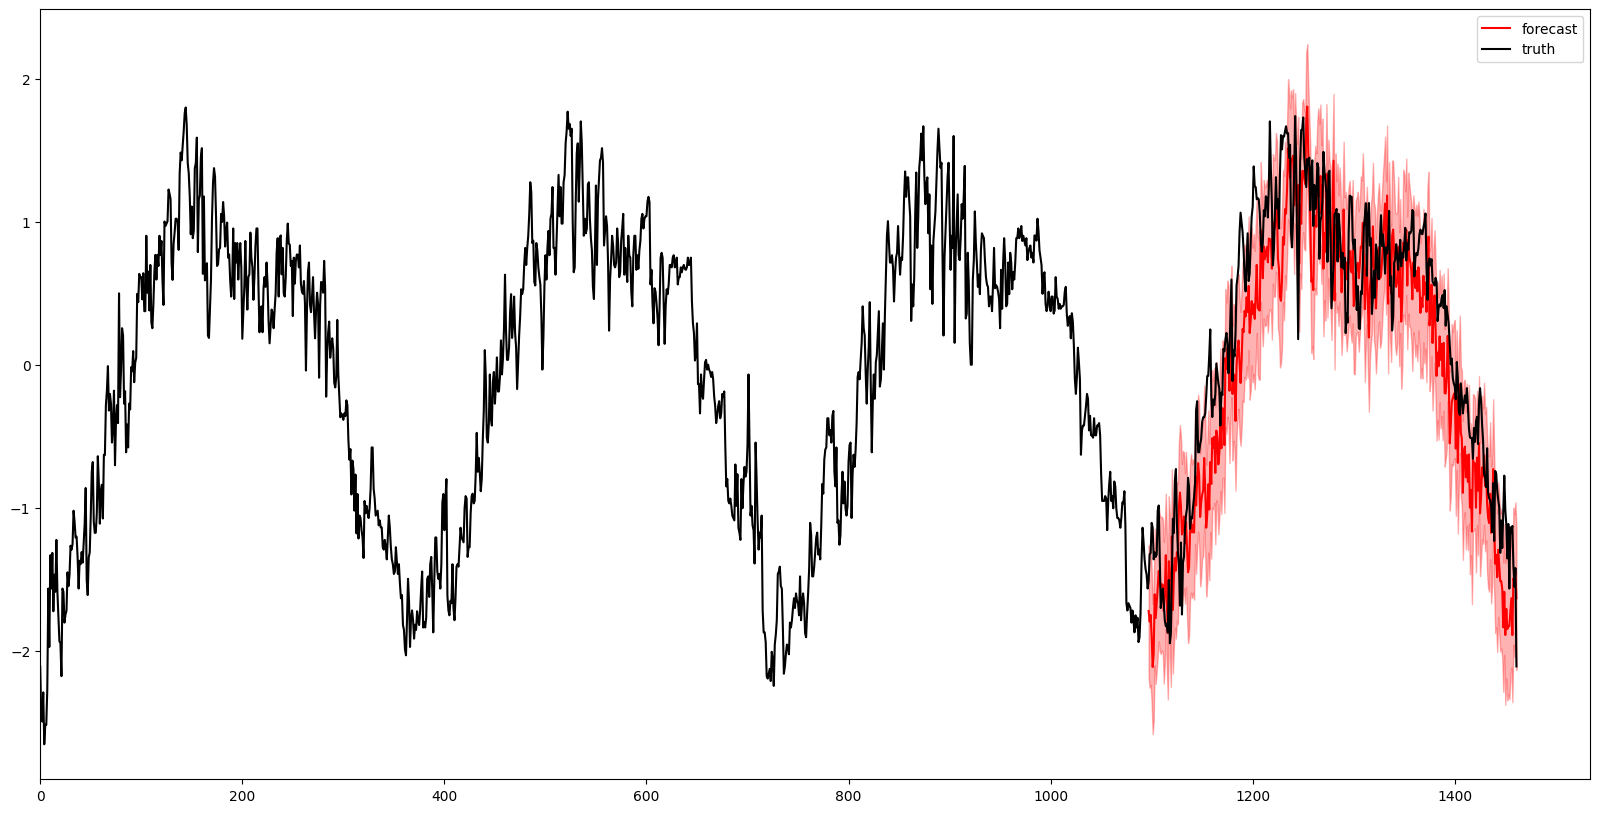

In [78]:
samples = forecaster(data[:mid], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[mid:])

plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.xlim(0, None)
plt.legend(loc="best")
plt.show()

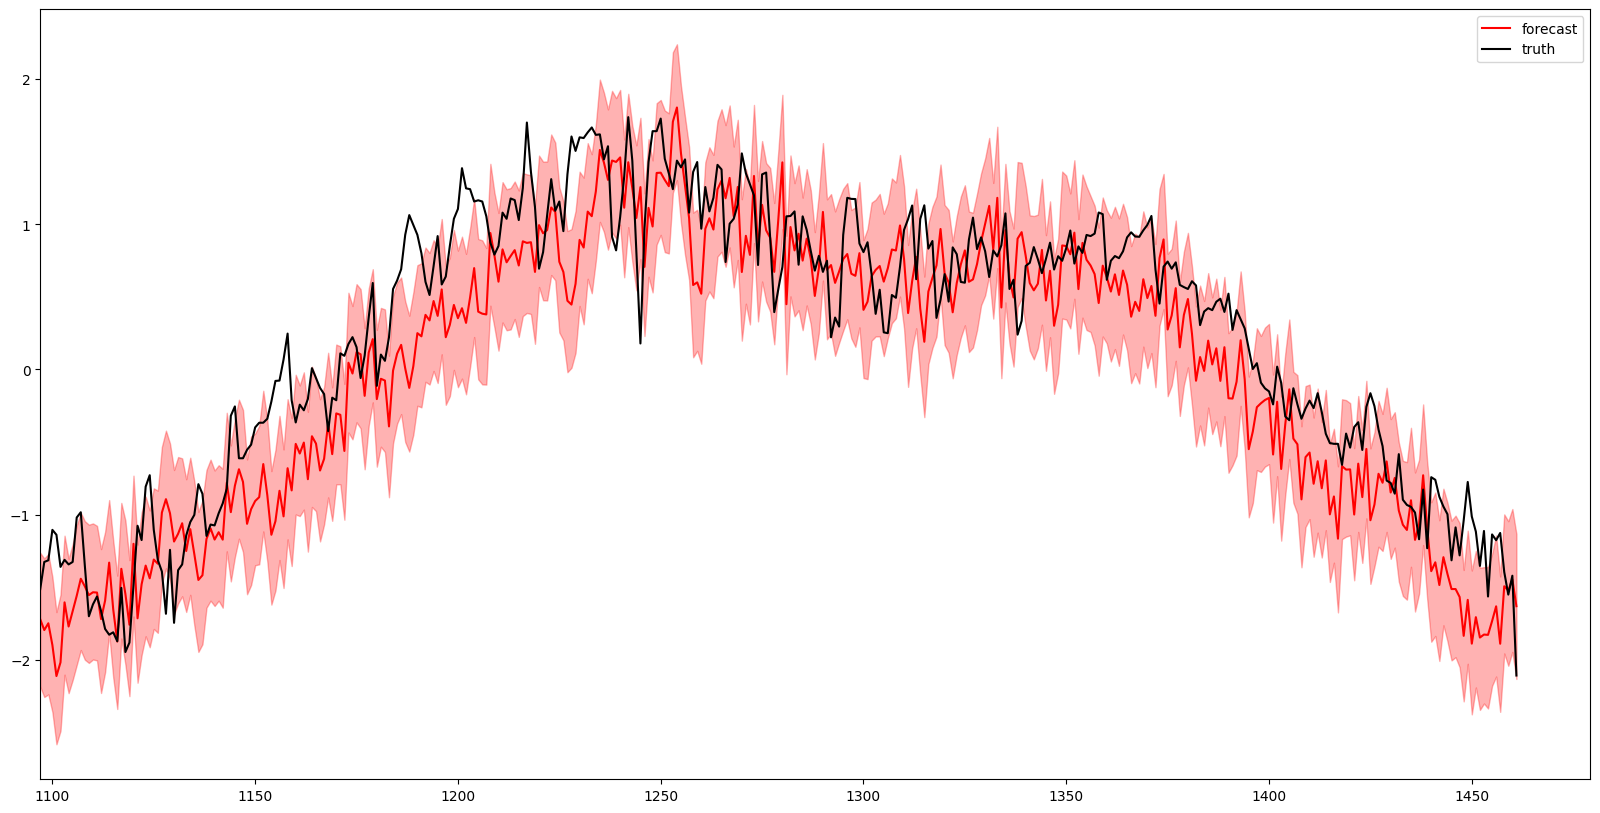

In [79]:
plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(torch.arange(mid, end), data[mid:], 'k-', label='truth')
plt.xlim(mid, None)
plt.legend(loc="best")
plt.show()

In [80]:
# get the total error

from sklearn.metrics import mean_squared_error

print("MSE: ", mean_squared_error(data[mid:], p50))

MSE:  0.1907196


So far we’ve seen the `ForecastingModel.model()` method and `self.predict()`. The last piece of forecasting-specific syntax is the `self.time_plate` context for time-local variables. To see how this works, consider changing our global linear trend model above to a local level model. Note the `poutine.reparam()` handler is a general Pyro inference trick, not specific to forecasting.

In [81]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [82]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(end)) / 365
# covariates = torch.stack([time], dim=-1)
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(end, 365)], dim=-1)
forecaster = Forecaster(Model2(), data[:mid], covariates[:mid], learning_rate=0.1, time_reparam="dct", num_steps=1000)

/Users/krishanu/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/pyro/poutine/reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 608357


INFO 	 step  100 loss = 1.71966
INFO 	 step  200 loss = 1.44376
INFO 	 step  300 loss = 1.27876
INFO 	 step  400 loss = 1.19555
INFO 	 step  500 loss = 1.07669
INFO 	 step  600 loss = 1.02725
INFO 	 step  700 loss = 1.01653
INFO 	 step  800 loss = 0.966158
INFO 	 step  900 loss = 0.92254


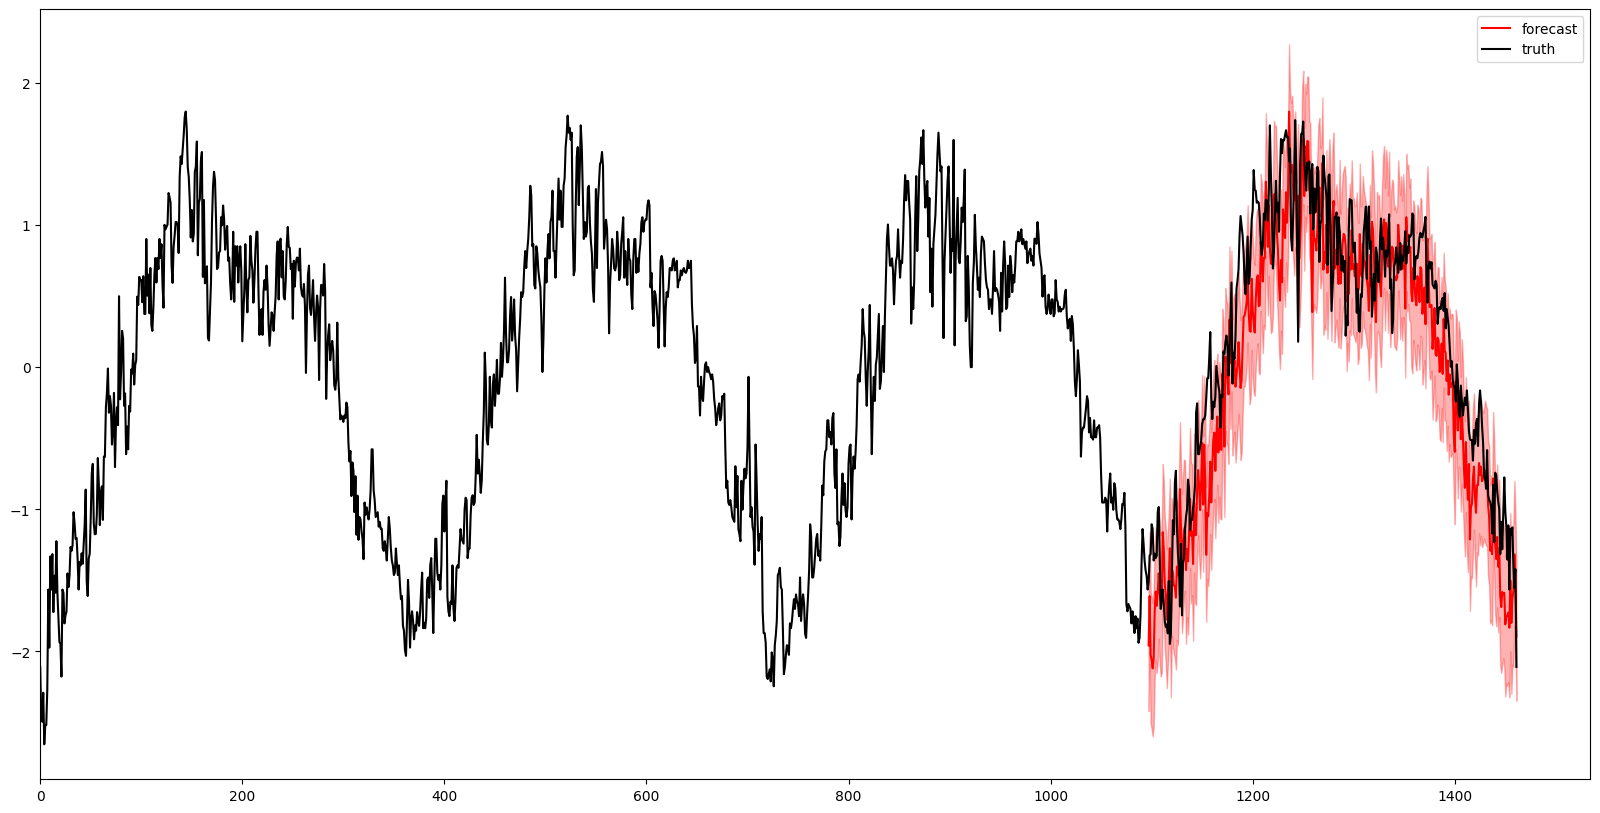

In [83]:
samples = forecaster(data[:mid], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[mid:])

plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.xlim(0, None)
plt.legend(loc="best")
plt.show()

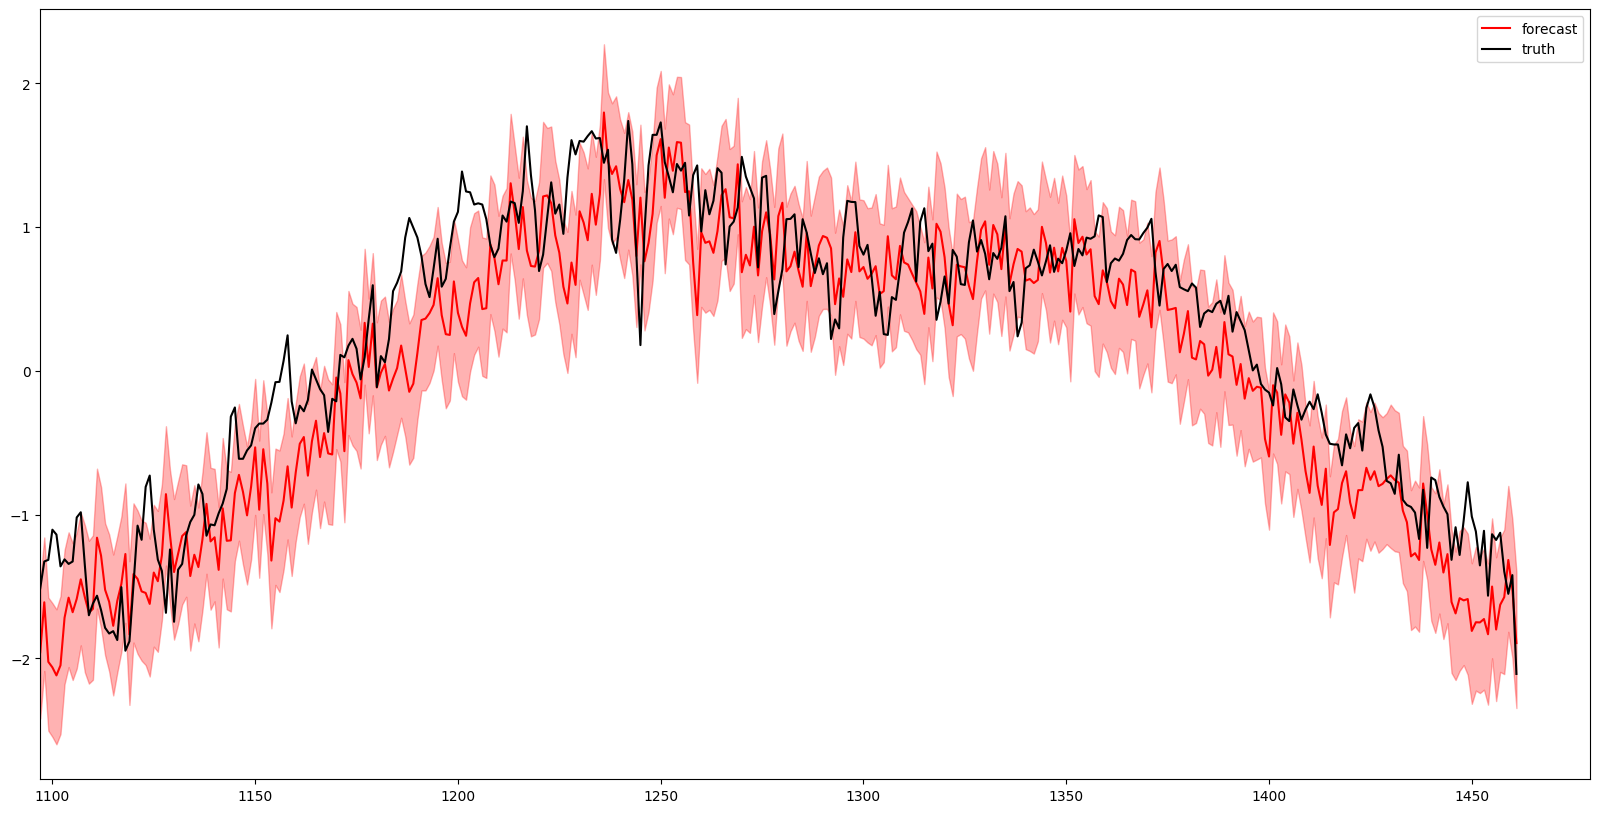

In [84]:
plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(torch.arange(mid, end), data[mid:], 'k-', label='truth')
plt.xlim(mid, None)
plt.legend(loc="best")
plt.show()

In [85]:
# get the total error

from sklearn.metrics import mean_squared_error

print("MSE: ", mean_squared_error(data[mid:], p50))

MSE:  0.1799405


In [86]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))
        motion = drift.cumsum(-2)  # A Brownian motion.

        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale)

        # We need to use a reparameterizer to handle the Stable distribution.
        # Note "residual" is the name of Pyro's internal sample site in self.predict().
        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)

In [87]:
pyro.set_rng_seed(2)
pyro.clear_param_store()
time = torch.arange(float(end)) / 365
covariates = periodic_features(end, 365)
forecaster = Forecaster(Model3(), data[:mid], covariates[:mid], learning_rate=0.1,
                        time_reparam="dct")
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

/Users/krishanu/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/pyro/poutine/reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 7.25409e+06
INFO 	 step  100 loss = 7.93064
INFO 	 step  200 loss = 2.28548
INFO 	 step  300 loss = 1.52472
INFO 	 step  400 loss = 1.41117
INFO 	 step  500 loss = 1.3362
INFO 	 step  600 loss = 1.31927
INFO 	 step  700 loss = 1.33258
INFO 	 step  800 loss = 1.17822
INFO 	 step  900 loss = 1.09924
INFO 	 step 1000 loss = 1.1394


bias = -0.06821
drift_scale = 1.257e-08
noise_stability = 1.995
noise_skew = 0.004022
noise_scale = 0.2305


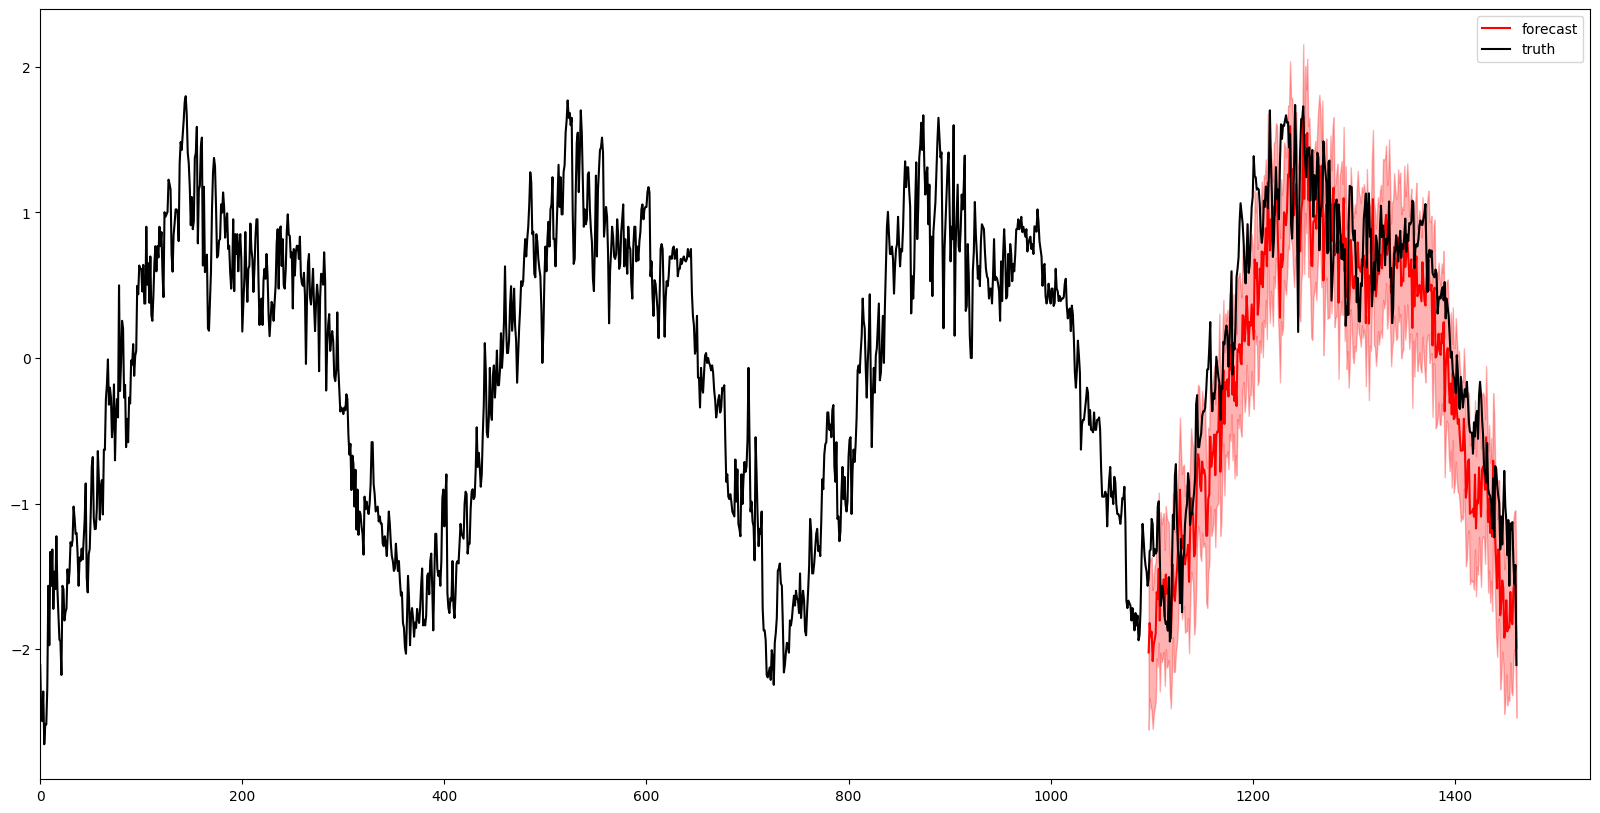

In [88]:
samples = forecaster(data[:mid], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[mid:])

plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.xlim(0, None)
plt.legend(loc="best")
plt.show()

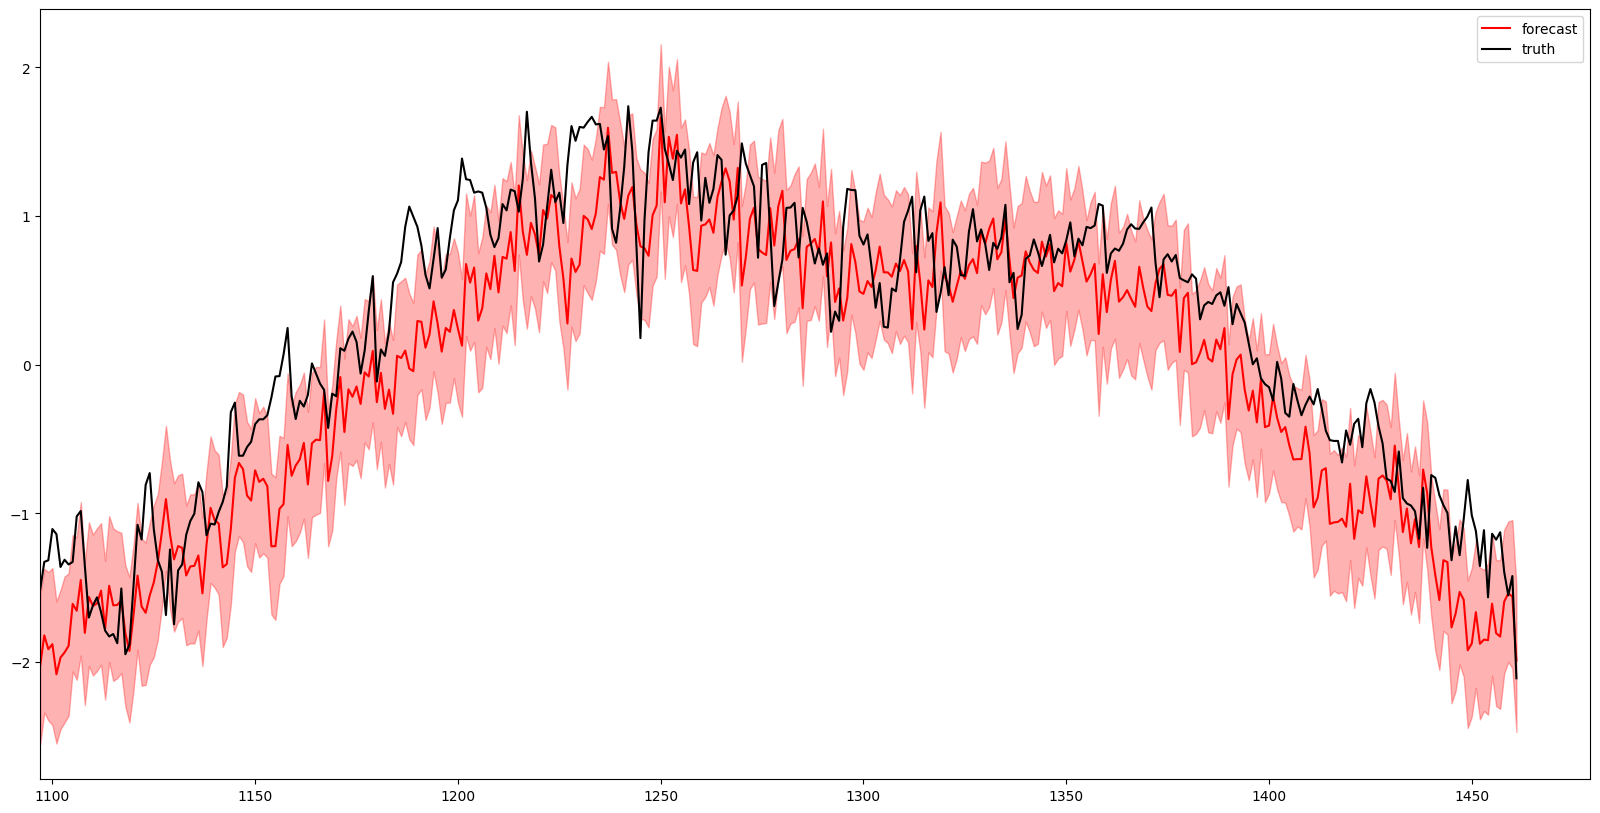

In [89]:
plt.figure(figsize=(20, 10))
plt.fill_between(torch.arange(mid, end), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(mid, end), p50, 'r-', label='forecast')
plt.plot(torch.arange(mid, end), data[mid:], 'k-', label='truth')
plt.xlim(mid, None)
plt.legend(loc="best")
plt.show()